In [748]:
import pandas as pd
import numpy as np
import pymorphy2

In [749]:
from matplotlib import pyplot as plt
import catboost as cb
import xgboost as xgb

In [750]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold

In [751]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [752]:
train = pd.read_csv('train.csv', sep = ';')
test = pd.read_csv('test.csv', sep = ';',low_memory=False)

In [755]:
FO = pd.read_excel('regions.xlsx')
rosstat = pd.read_excel('Sr._denezhnye_dokhody.xlsx')
rosstat = rosstat.loc[:,['region','среднее за 2019г']]
FO = FO.set_index('region').join(rosstat.set_index('region')).reset_index()

In [756]:
vyz = pd.read_csv('education_mult.csv', sep = ';',low_memory=False)
vyz.institution = vyz.institution.str.lower()
vyz.institution = vyz.institution.str.replace(r'[^\w\s]+', ' ')
vyz.institution = vyz.institution.str.replace(r' +', ' ')

In [757]:
vyz = vyz.drop(columns = ['description'])
vyz = vyz.dropna(subset = ['id'])
vyz = vyz.drop_duplicates(subset = ['id'])

In [758]:
experi = pd.read_csv('employements_mult.csv', sep = ';',low_memory=False)

In [759]:
experi = experi.dropna(subset = ['id'])
experi = experi.dropna(subset = ['achievements'])

In [765]:
train = train.set_index('region').join(FO.set_index('region'), on = 'region').reset_index()
test = test.set_index('region').join(FO.set_index('region'), on = 'region').reset_index()

In [766]:
train = train.set_index('id').join(vyz.set_index('id'), on = 'id', how='left').reset_index()
test = test.set_index('id').join(vyz.set_index('id'), on = 'id', how='left').reset_index()

In [767]:
test['institution'].fillna(0, inplace = True)
train['institution'].fillna(0, inplace = True)
train['graduation_year'].fillna(0, inplace = True)
test['graduation_year'].fillna(0, inplace = True)

In [770]:
morph = pymorphy2.MorphAnalyzer()
train['position'] = train['position'].apply(lambda x: morph.parse(x)[0].normal_form)
train['position'] = train['position'].str.replace(r'[^\w\s]+', ' ')
train['position'] = train['position'].str.replace(r' +', ' ')

In [804]:
data_for_train = train['salary_desired']
data_for_train = pd.DataFrame(data_for_train)

data_for_train.loc[(data_for_train.salary_desired < 200) & (data_for_train.salary_desired > 9),'salary_desired'] = data_for_train.loc[(data_for_train.salary_desired < 200) & (data_for_train.salary_desired > 9),'salary_desired']*1000
data_for_train.loc[(data_for_train.salary_desired > 300000) & (train.industry != 'Высший менеджмент'),'salary_desired'] = data_for_train.loc[((data_for_train.salary_desired > 300000) & (train.industry != 'Высший менеджмент')),'salary_desired']*0.1 
data_for_train.loc[(data_for_train.salary_desired < 0),'salary_desired'] = data_for_train.loc[(data_for_train.salary_desired < 0),'salary_desired']*(-1)


data_for_train = data_for_train.join(pd.get_dummies( train['education_type'], dummy_na=True, prefix='Education'))
data_for_train = data_for_train.join(pd.get_dummies( train['gender'], dummy_na=True, prefix='Gender'))
data_for_train = data_for_train.join(pd.get_dummies( train['industry'], dummy_na=True, prefix='Industry'))
data_for_train = data_for_train.join(pd.get_dummies( train['relocation_ready'], dummy_na=True, prefix='relocation_ready'))
data_for_train = data_for_train.join(pd.get_dummies( train['travel_ready'], dummy_na=True, prefix='travel_ready'))
data_for_train = data_for_train.join(pd.get_dummies( train['retraining_ready'], dummy_na=True, prefix='retraining_ready'))

data_for_train = data_for_train.join(pd.get_dummies( train['region'], dummy_na=True, prefix='region'))

# data_for_train = data_for_train.join(pd.get_dummies( train['FO'], dummy_na=True, prefix='FO'))
########################################################
# data_for_train['Zanyatost_full'] = train['employement_type'].isin(['Полная занятость']).astype(int)
data_for_train['Zanyatost_part'] = train['employement_type'].isin(['Частичная занятость']).astype(int)
data_for_train['Zanyatost_remote'] = train['employement_type'].isin(['Удаленная']).astype(int)
data_for_train['Zanyatost_Season'] = train['employement_type'].isin(['Временная','Сезонная','Стажировка']).astype(int)

data_for_train['citizenship'] = train['citizenship'].isin(['Российская Федерация']).astype(int)

# data_for_train['Moscow'] = train['region'].isin(['г. Москва']).astype(int)
# data_for_train['Mos_reg'] = train['region'].isin(['Московская область']).astype(int)
# data_for_train['SBP'] = train['region'].isin(['г. Санкт-Петербург']).astype(int)

data_for_train['Director'] = (train['position'].str.contains('директор', regex=True) | 
                              train['position'].str.contains('начальник', regex=True) | 
                              train['position'].str.contains('руководитель', regex=True)).astype(int)

data_for_train['Main'] = (train['position'].str.contains('главный', regex=True) |
                          train['position'].str.contains('старший*', regex=True)|
                         train['position'].str.contains('ведущий', regex=True)).astype(int)

data_for_train['Master'] = (train['position'].str.contains('инженер*', regex=True)).astype(int)

data_for_train['Programmist'] = (train['position'].str.contains('программист*', regex=True)|
                          train['position'].str.contains('разработчик', regex=True)).astype(int)
data_for_train['Accountant'] = (train['position'].str.contains('бухгалтер', regex=True)).astype(int)
data_for_train['Specialist'] = (train['position'].str.contains('специалист*', regex=True)).astype(int)
data_for_train['Helper'] = (train['position'].str.contains('помощник', regex=True)).astype(int)
data_for_train['Lawyer'] = (train['position'].str.contains('юрис', regex=True)).astype(int)
# data_for_train['Football'] = train['position'].str.contains('футбол', regex=True).astype(int)
# data_for_test['Goss'] = (train['position'].str.contains('госуд', regex=True)|
#                           train['position'].str.contains('госс', regex=True)).astype(int)

data_for_train['Academy'] = (train['institution'].str.contains('академия', regex=True)).fillna(0).astype('int')
data_for_train['Univer'] = (train['institution'].str.contains('университет', regex=True)).fillna(0).astype('int')
data_for_train['Institut'] = (train['institution'].str.contains('институт', regex=True)).fillna(0).astype('int')

data_for_train['MSU'] = (train['institution'].str.contains('мгу', regex=True)).fillna(0).astype('int')
data_for_train['Bomonka'] = (train['institution'].str.contains('баумана', regex=True)).fillna(0).astype('int')
data_for_train['SPBGY'] = (train['institution'].str.contains('спбгу', regex=True)).fillna(0).astype('int')
data_for_train['hse'] = (train['institution'].str.contains('вшэ', regex=True)|train['institution'].str.contains('школа экономики', regex=True)).fillna(0).astype('int')
data_for_train['mifi'] = (train['institution'].str.contains('мифи', regex=True)).fillna(0).astype('int')
data_for_train['Gubk'] = (train['institution'].str.contains('губкин', regex=True)).fillna(0).astype('int')

data_for_train['Grad_year'] = 2020 - train['graduation_year']
data_for_train['Publish_year'] = 2020 - pd.to_datetime(train.publish_date).dt.year
data_for_train['Rosstat_salary'] = train['среднее за 2019г']
data_for_train['Achievments'] = train['id'].isin(experi.id.unique().astype('int')).astype('int')


specialties = ['менедж', 'охран', 'экон', 'водит', 'препод',  'врач', 'убор', 'уч', 'анал', 'марк', 'строит', 
'админ', 'продав', 'касс', 'офиц', 'груз', 'клад', 'продаж', 'фин', 'торг', 'стаж', 'повар', 
 'шеф', 'it', 'нефт', 'газ', 'элект', 'секрет', 'гос', 'маст', 'слес', 'бар']

# specialties = ['нач', 'менедж', 'охран', 'бух', 'экон', 'вод', 'препод', 'инж', 'врач', 'убор', 'уч', 'анал', 'марк', 'юр', 'строит', 'прогр',
# 'админ', 'руков', 'продав', 'касс', 'офиц', 'груз', 'клад', 'продаж', 'фин', 'торг', 'глав', 'млад', 'стаж', 'разраб', 'повар', 
#  'шеф', 'дир', 'it', 'нефт', 'газ', 'элект', 'секрет', 'гос', 'помощ', 'маст', 'слес', 'бар']

train.position = train.position.apply(lambda x: x.lower())
for position in specialties:
    data_for_train[f'position_{position}'] = train.position.apply(lambda x: int(position in x) if type(x) == str else x)

########################################################
licence_list = ['A', 'B', 'C', 'D', 'E']
for licence in licence_list:
    data_for_train[f'licence_{licence}'] = train.drive_licences.apply(lambda x: int(licence in x) if type(x) == str else x)

schedule_list = ['Полный', 'Вахтовый', 'Гибкий', 'Неполный', 'Сменный', 'Ненормированный']
for schedule in schedule_list:
    data_for_train[f'{schedule}'] = train.schedule.apply(lambda x: int(schedule in x) if type(x) == str else x)    
    
########################################################
data_for_train = data_for_train.join(train['age'])
data_for_train = data_for_train.join(train['experience'])
# data_for_train = data_for_train.join(train['completeness_rate'])

########################################################
data_for_train['age'] = data_for_train['age'].fillna(100) 
data_for_train.loc[data_for_train.experience > (data_for_train.age - 14),'experience'] = data_for_train.loc[data_for_train.experience > (data_for_train.age - 14),'age'] -14
########################################################
data_for_train.fillna(0, inplace = True)
########################################################
data_for_train.drop(columns = ['Industry_Начал трудовую деятельность','Industry_nan'], inplace = True)

data_for_train.drop(columns = ['region_nan','region_г. Байконур'], inplace = True)

In [805]:
data_for_test = test['salary_desired']
data_for_test = pd.DataFrame(data_for_test)

data_for_test.loc[(data_for_test.salary_desired < 200) & (data_for_test.salary_desired > 9),'salary_desired'] = data_for_test.loc[(data_for_test.salary_desired < 200) & (data_for_test.salary_desired > 9),'salary_desired']*1000
data_for_test.loc[(data_for_test.salary_desired > 300000) & (test.industry != 'Высший менеджмент'),'salary_desired'] = data_for_test.loc[((data_for_test.salary_desired > 300000) & (test.industry != 'Высший менеджмент')),'salary_desired']*0.1 
data_for_test.loc[(data_for_test.salary_desired < 0),'salary_desired'] = data_for_test.loc[(data_for_test.salary_desired < 0),'salary_desired']*(-1)


data_for_test = data_for_test.join(pd.get_dummies( test['education_type'], dummy_na=True, prefix='Education'))
data_for_test = data_for_test.join(pd.get_dummies( test['gender'], dummy_na=True, prefix='Gender'))
data_for_test = data_for_test.join(pd.get_dummies( test['industry'], dummy_na=True, prefix='Industry'))
data_for_test = data_for_test.join(pd.get_dummies( test['relocation_ready'], dummy_na=True, prefix='relocation_ready'))
data_for_test = data_for_test.join(pd.get_dummies( test['travel_ready'], dummy_na=True, prefix='travel_ready'))
data_for_test = data_for_test.join(pd.get_dummies( test['retraining_ready'], dummy_na=True, prefix='retraining_ready'))

data_for_test = data_for_test.join(pd.get_dummies( test['region'], dummy_na=True, prefix='region'))

# data_for_test = data_for_test.join(pd.get_dummies( test['FO'], dummy_na=True, prefix='FO'))
########################################################
# data_for_test['Zanyatost_full'] = test['employement_type'].isin(['Полная занятость']).astype(int)
data_for_test['Zanyatost_part'] = test['employement_type'].isin(['Частичная занятость']).astype(int)
data_for_test['Zanyatost_remote'] = test['employement_type'].isin(['Удаленная']).astype(int)
data_for_test['Zanyatost_Season'] = test['employement_type'].isin(['Временная','Сезонная','Стажировка']).astype(int)

data_for_test['citizenship'] = test['citizenship'].isin(['Российская Федерация']).astype(int)

# data_for_test['Moscow'] = test['region'].isin(['г. Москва']).astype(int)
# data_for_test['Mos_reg'] = test['region'].isin(['Московская область']).astype(int)
# data_for_test['SBP'] = test['region'].isin(['г. Санкт-Петербург']).astype(int)

data_for_test['Director'] = (test['position'].str.contains('директор', regex=True) | 
                              test['position'].str.contains('начальник', regex=True) | 
                              test['position'].str.contains('руководитель', regex=True)).astype(int)

data_for_test['Main'] = (test['position'].str.contains('главный', regex=True) |
                          test['position'].str.contains('старший*', regex=True)|
                         test['position'].str.contains('ведущий', regex=True)).astype(int)

data_for_test['Master'] = (test['position'].str.contains('инженер*', regex=True)).astype(int)

data_for_test['Programmist'] = (test['position'].str.contains('программист*', regex=True)|
                          test['position'].str.contains('разработчик', regex=True)).astype(int)

# data_for_test['Goss'] = (test['position'].str.contains('госуд', regex=True)|
#                           test['position'].str.contains('госс', regex=True)).astype(int)
data_for_test['Accountant'] = (test['position'].str.contains('бухгалтер', regex=True)).astype(int)
data_for_test['Specialist'] = (test['position'].str.contains('специалист*', regex=True)).astype(int)
data_for_test['Helper'] = (test['position'].str.contains('помощник', regex=True)).astype(int)
data_for_test['Lawyer'] = (test['position'].str.contains('юрис', regex=True)).astype(int)
# data_for_test['Football'] = test['position'].str.contains('футбол', regex=True).astype(int)

data_for_test['Academy'] = (test['institution'].str.contains('академия', regex=True)).fillna(0).astype('int')
data_for_test['Univer'] = (test['institution'].str.contains('университет', regex=True)).fillna(0).astype('int')
data_for_test['Institut'] = (test['institution'].str.contains('институт', regex=True)).fillna(0).astype('int')

data_for_test['MSU'] = (test['institution'].str.contains('мгу', regex=True)).fillna(0).astype('int')
data_for_test['Bomonka'] = (test['institution'].str.contains('баумана', regex=True)).fillna(0).astype('int')
data_for_test['SPBGY'] = (test['institution'].str.contains('спбгу', regex=True)).fillna(0).astype('int')
data_for_test['hse'] = (test['institution'].str.contains('вшэ', regex=True)|test['institution'].str.contains('школа экономики', regex=True)).fillna(0).astype('int')
data_for_test['mifi'] = (test['institution'].str.contains('мифи', regex=True)).fillna(0).astype('int')
data_for_test['Gubk'] = (test['institution'].str.contains('губкин', regex=True)).fillna(0).astype('int')

data_for_test['Grad_year'] = 2020 - test['graduation_year']
data_for_test['Publish_year'] = 2020 - pd.to_datetime(test.publish_date).dt.year

data_for_test['Rosstat_salary'] = test['среднее за 2019г']
data_for_test['Achievments'] = test['id'].isin(experi.id.unique().astype('int')).astype('int')

specialties = ['менедж', 'охран', 'экон', 'водит', 'препод',  'врач', 'убор', 'уч', 'анал', 'марк', 'строит', 
'админ', 'продав', 'касс', 'офиц', 'груз', 'клад', 'продаж', 'фин', 'торг', 'стаж', 'повар', 
 'шеф', 'it', 'нефт', 'газ', 'элект', 'секрет', 'гос',  'маст', 'слес', 'бар']

# specialties = ['нач', 'менедж', 'охран', 'бух', 'экон', 'вод', 'препод', 'инж', 'врач', 'убор', 'уч', 'анал', 'марк', 'юр', 'строит', 'прогр',
# 'админ', 'руков', 'продав', 'касс', 'офиц', 'груз', 'клад', 'продаж', 'фин', 'торг', 'глав', 'млад', 'стаж', 'разраб', 'повар', 
#  'шеф', 'дир', 'it', 'нефт', 'газ', 'элект', 'секрет', 'гос', 'помощ', 'маст', 'слес', 'бар']

test.position = test.position.apply(lambda x: x.lower())
for position in specialties:
    data_for_test[f'position_{position}'] = test.position.apply(lambda x: int(position in x) if type(x) == str else x)

########################################################
licence_list = ['A', 'B', 'C', 'D', 'E']
for licence in licence_list:
    data_for_test[f'licence_{licence}'] = test.drive_licences.apply(lambda x: int(licence in x) if type(x) == str else x)

schedule_list = ['Полный', 'Вахтовый', 'Гибкий', 'Неполный', 'Сменный', 'Ненормированный']
for schedule in schedule_list:
    data_for_test[f'{schedule}'] = test.schedule.apply(lambda x: int(schedule in x) if type(x) == str else x)    
    
########################################################
data_for_test = data_for_test.join(test['age'])
data_for_test = data_for_test.join(test['experience'])
# data_for_test = data_for_test.join(test['completeness_rate'])

########################################################
data_for_test['age'] = data_for_test['age'].fillna(100) 
data_for_test.loc[data_for_test.experience > (data_for_test.age - 14),'experience'] = data_for_test.loc[data_for_test.experience > (data_for_test.age - 14),'age'] -14
########################################################
data_for_test.fillna(0, inplace = True)
########################################################
data_for_test.drop(columns = ['Industry_Начал трудовую деятельность','Industry_nan'], inplace = True)

data_for_test.drop(columns = ['region_nan','region_г. Байконур'], inplace = True)

# ---------


In [ ]:
kf = KFold(n_splits=4,shuffle=True)
for train_index, test_index in kf.split(data_for_train):
    X_train, X_test = data_for_train.loc[train_index,:], data_for_train.loc[test_index,:]
    y_train, y_test = train.loc[train_index,'salary'], train.loc[test_index,'salary']
    X_val = X_train.iloc[:int(0.2*len(X_train)), :]
    y_val = y_train.iloc[:int(0.2*len(y_train))]
    reg_CB_bag = cb.CatBoostRegressor(od_wait=15,thread_count = 6, max_depth=10, eval_metric = 'MSLE').fit(X_train, y_train, verbose=False, eval_set=(X_val, y_val))
    y_pred_CB_Bagging = reg_CB_bag.predict(X_test)
    y_pred_CB_Bagging = pd.Series(y_pred_CB_Bagging).apply(lambda x: 5000 if x < 5000 else x).array
    print('CatBoost: %.5f'
              % mean_squared_log_error(y_test, y_pred_CB_Bagging)**0.5)

In [821]:
X_val = data_for_train.iloc[:int(0.2*len(data_for_train)), :]
y_val = train['salary'].iloc[:int(0.2*len(train['salary']))]
reg_CB_bag = cb.CatBoostRegressor(od_wait=15,thread_count = 6, max_depth=10, eval_metric = 'MSLE').fit(data_for_train, train['salary'], verbose=False, eval_set=(X_val, y_val))
y_pred_CB_Bagging = reg_CB_bag.predict(data_for_train)
y_pred_CB_Bagging = pd.Series(y_pred_CB_Bagging).apply(lambda x: 5000 if x < 5000 else x).array
print('CatBoost: %.5f'
              % mean_squared_log_error(train['salary'], y_pred_CB_Bagging)**0.5)

CatBoost: 1.00834


In [824]:
np.abs(pd.Series(train['salary']- y_pred_CB_Bagging)).mean()

13201.811960881794

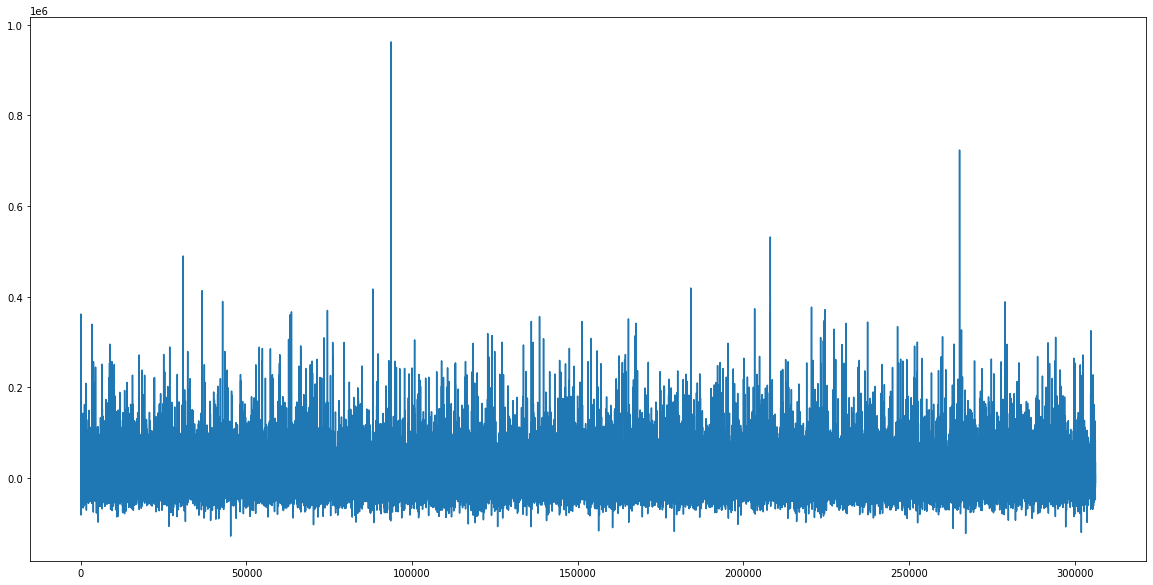

In [822]:
pd.Series(train['salary']- y_pred_CB_Bagging).plot(figsize = (20,10))

In [ ]:
kf = KFold(n_splits=4,shuffle=True)
val_score = []
for train_index, test_index in kf.split(data_for_train):
    X_train, X_test = data_for_train.loc[train_index,:], data_for_train.loc[test_index,:]
    y_train, y_test = train.loc[train_index,'salary'], train.loc[test_index,'salary']
    ################## модель
    reg_RF_bag = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth=10),n_jobs = 6, n_estimators = 30 ).fit(X_train, y_train)
    reg_OLS = BaggingRegressor(base_estimator = LinearRegression(),n_jobs = 6, n_estimators= 30 ).fit(X_train, y_train)
    ################## 
    X_val = X_train.iloc[:int(0.2*len(X_train)), :]
    y_val = y_train.iloc[:int(0.2*len(y_train))]
    reg_CB_bag = cb.CatBoostRegressor(od_wait=15,thread_count = 6).fit(X_train, y_train, verbose=False, eval_set=(X_val, y_val))
    y_pred_CB_Bagging = reg_CB_bag.predict(X_test)
    y_pred_CB_Bagging[y_pred_CB_Bagging < 0] = 5000
    ################## 
    reg_XGB_bag = xgb.XGBRegressor(objective ='reg:squaredlogerror', max_depth = 10, n_estimators = 50, n_jobs = 6).fit(X_train,y_train)
    y_pred_XGB_Bagging = reg_XGB_bag.predict(X_test)
    y_pred_XGB_Bagging[y_pred_XGB_Bagging < 0] = 5000

    y_pred_RF_Bagging = reg_RF_bag.predict(X_test)
    y_pred_OLS = reg_OLS.predict(X_test)
    y_pred_OLS[y_pred_OLS < 0] = 5000
    y_pred_test = (y_pred_OLS+y_pred_RF_Bagging+ y_pred_CB_Bagging+y_pred_XGB_Bagging)/4
    y_pred_test_BOOST = ( y_pred_CB_Bagging+y_pred_XGB_Bagging)/2
    y_pred_test = pd.Series(y_pred_test).apply(lambda x: 5000 if x < 5000 else x).array
    y_pred_test_BOOST = pd.Series(y_pred_test_BOOST).apply(lambda x: 5000 if x < 5000 else x).array

    ################## смотрим на ошибку
    print('---------------')
    val_score.append(mean_squared_log_error(y_test, y_pred_test)**0.5)
    print('RMSLE TOTAL: %.5f'
      % mean_squared_log_error(y_test, y_pred_test)**0.5)
    ################## 
    print('RMSLE OLS: %.5f'
      % mean_squared_log_error(y_test, y_pred_OLS)**0.5)
    ################## 
    print('RMSLE RF Bag: %.5f'
      % mean_squared_log_error(y_test, y_pred_RF_Bagging)**0.5)
    ##################
    print('RMSLE CatBoost: %.5f'
              % mean_squared_log_error(y_test, y_pred_CB_Bagging)**0.5)
    
    print('XGB: %.5f'
              % mean_squared_log_error(y_test, y_pred_XGB_Bagging)**0.5)
    print('XGB+CatBoost: %.5f'
      % mean_squared_log_error(y_test, y_pred_test_BOOST)**0.5)
    print('---------------')
       

In [ ]:
pd.Series(val_score).mean()

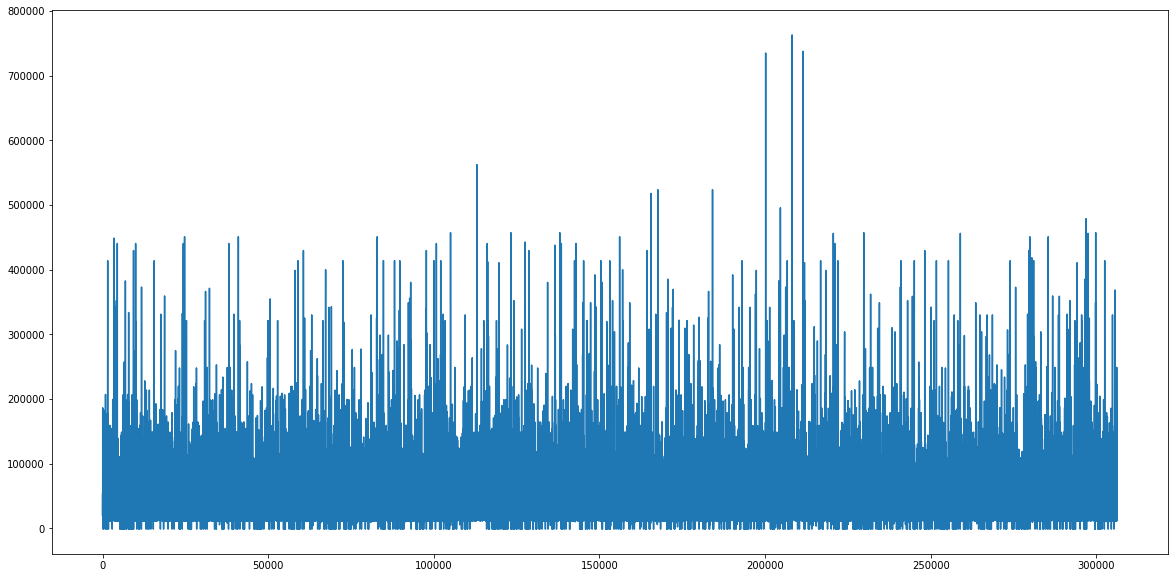

In [837]:
pd.Series(y_test-y_pred_XGB_Bagging).plot(figsize = (20,10))

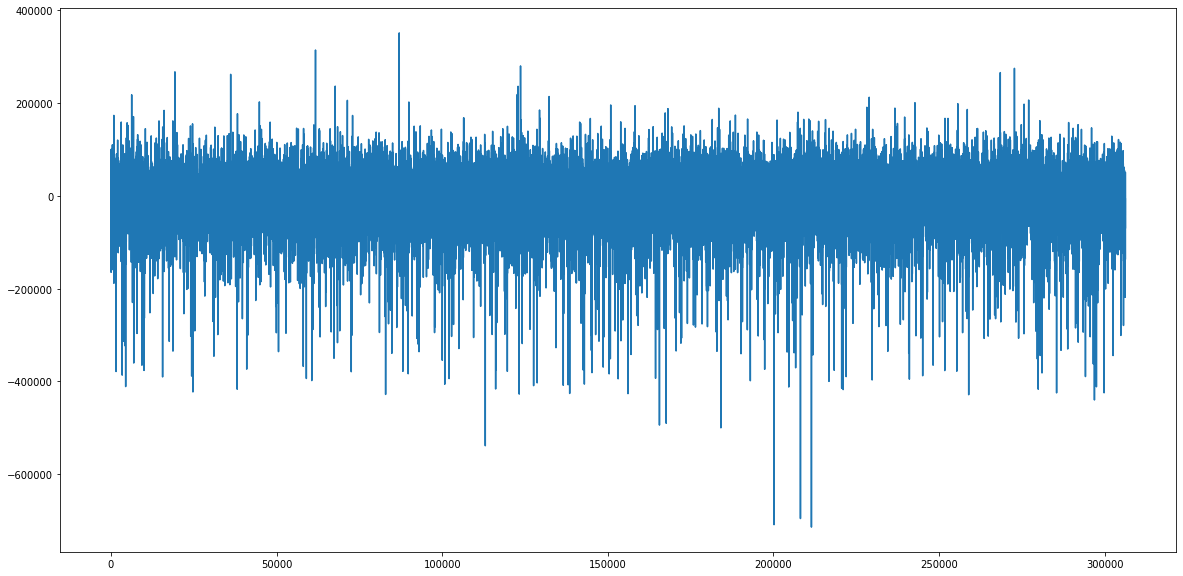

In [838]:
pd.Series(y_pred_CB_Bagging - y_test).plot(figsize = (20,10))

In [ ]:
pd.Series(val_score).mean()

# -----------------

In [ ]:
kf = KFold(n_splits=4,shuffle=True)
for train_index, test_index in kf.split(data_for_train):
    X_train, X_test = data_for_train.loc[train_index,:], data_for_train.loc[test_index,:]
    y_train, y_test = train.loc[train_index,'salary'], train.loc[test_index,'salary']
    for i in range(3,12):
        reg_RF_Ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=i) ).fit(X_train, y_train)
        y_pred_RF_Ada = reg_RF_Ada.predict(X_test)
        print(i)
        print('mean_squared_log_error: %.3f'
              % mean_squared_log_error(y_test, y_pred_RF_Ada)**0.5)

# -----------------

In [ ]:
kf = KFold(n_splits=4,shuffle=True)
for train_index, test_index in kf.split(data_for_train):
    X_train, X_test = data_for_train.loc[train_index,:], data_for_train.loc[test_index,:]
    y_train, y_test = train.loc[train_index,'salary'], train.loc[test_index,'salary']
    for i in range(5,12):
        reg_RF_bag = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth=i),n_jobs = 6 ).fit(X_train, y_train)
        y_pred_RF_Bagging = reg_RF_bag.predict(X_test)
        print(i)
        print('mean_squared_log_error: %.3f'
              % mean_squared_log_error(y_test, y_pred_RF_Bagging)**0.5)

In [ ]:
kf = KFold(n_splits=4,shuffle=True)
for train_index, test_index in kf.split(data_for_train):
    X_train, X_test = data_for_train.loc[train_index,:], data_for_train.loc[test_index,:]
    y_train, y_test = train.loc[train_index,'salary'], train.loc[test_index,'salary']
    for i in range(5,12):
        reg_XGB_bag = xgb.XGBRegressor(objective ='reg:squarederror', max_depth = 10, n_estimators = 50, n_jobs = 6).fit(X_train,y_train)
        y_pred_XGB_Bagging = reg_XGB_bag.predict(X_test)
        y_pred_XGB_Bagging[y_pred_XGB_Bagging < 0] = 5000
        print(i)
        print('XGB: %.5f'
              % mean_squared_log_error(y_test, y_pred_XGB_Bagging)**0.5)

# -----------------

In [844]:
X_val = data_for_train.iloc[:int(0.2*len(data_for_train)), :]
y_val = train['salary'].iloc[:int(0.2*len(train['salary']))]
reg_CB_bag = cb.CatBoostRegressor(od_wait=15,thread_count = 6, max_depth=10, eval_metric = 'MSLE').fit(data_for_train, train['salary'], verbose=False, eval_set=(X_val, y_val))
y_pred_CB_Bagging = reg_CB_bag.predict(data_for_test)
y_pred_CB_Bagging = pd.Series(y_pred_CB_Bagging).apply(lambda x: 5000 if x < 5000 else x).array

In [853]:
reg_XGB_bag = xgb.XGBRegressor(objective ='reg:squarederror', max_depth = 10, n_estimators = 50, n_jobs = 6).fit(data_for_train, train['salary'])
y_pred_XGB_Bagging = reg_XGB_bag.predict(data_for_test)
y_pred_XGB_Bagging = pd.Series(y_pred_XGB_Bagging).apply(lambda x: 5000 if x < 5000 else x).array

In [860]:
# y_pred_CB_Bagging_final = (y_pred_CB_Bagging+y_pred_XGB_Bagging)/2
y_pred_CB_Bagging_final = y_pred_CB_Bagging

In [861]:
final_data = pd.concat([pd.Series(test['id']),pd.Series(y_pred_CB_Bagging_final)], axis = 1)

In [862]:
final_data[0].mean()

40814.3576841355

In [863]:
final_data

,id,0
0,2,30548.547492
1,6,70023.043967
2,7,40695.934365
3,11,28949.626137
4,16,59326.912625
...,...,...
131254,437515,22517.551738
131255,437518,41794.404074
131256,437526,42274.269601
131257,437527,39816.197091


In [864]:
final_data.columns = ['id','salary']

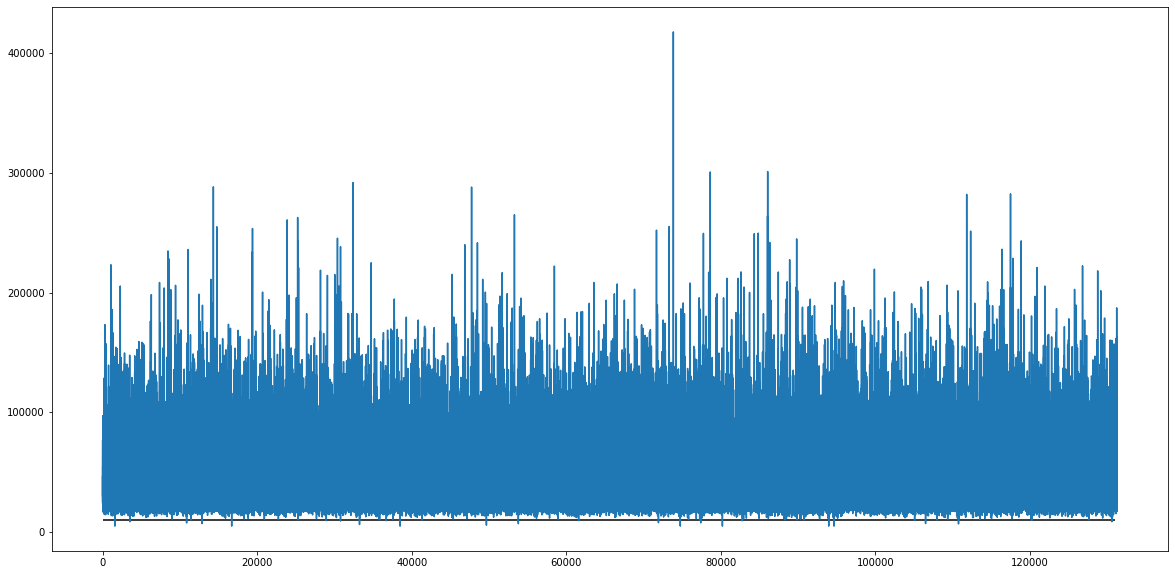

In [865]:
final_data['salary'].plot(figsize = (20,10))
plt.hlines(y=10000,xmin = 0, xmax = 131000)

In [852]:
final_data.to_csv('submission6.csv', index=False)